In [1]:
%pip install transformers rouge_score evaluate datasets av -q
%pip install accelerate -U -q

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [3]:
import av
import json
import pandas as pd
import numpy as np
from datasets import Dataset

def get_data(path):

    with open(path) as file:
        data = json.load(file)
        del data['info']
    data.keys()

    ds_video = pd.DataFrame(data['videos'])
    ds_caps = pd.DataFrame(data['sentences'])

    ds_caps = ds_caps.groupby('video_id').agg(list).reset_index('video_id')
    ds_caps['sen_id'] = ds_caps.apply(lambda x: x['sen_id'][0], axis=1)
    ds_caps['caption'] = ds_caps.apply(lambda x: x['caption'][0], axis=1)

    ds = ds_caps.merge(ds_video, on='video_id')
    ds_train = ds[ds['split'] == 'train']
    ds_val = ds[ds['split'] == 'validate']
    return Dataset.from_pandas(ds_train), Dataset.from_pandas(ds_val)

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    # end_idx = np.random.randint(converted_len, seg_len)
    end_idx = seg_len
    # start_idx = end_idx - converted_len
    start_idx = 0
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def get_path(video_id):
    dir = '/content/MSR-VTT/train_val_videos/TrainValVideo/'
    file_name = f'{video_id}.mp4'
    path = dir+file_name
    return path

def get_frames(path):
    # dir = 'D:/Datasets/MSR-VTT/train_val_videos/TrainValVideo/'
    # file_name = f'{item["video_id"]}.mp4'
    # path = get_path(item)
    container = av.open(path)

    num_frames = 8
    indices = sample_frame_indices(
        clip_len=num_frames, frame_sample_rate=4, seg_len=container.streams.video[0].frames
    )
    frames = read_video_pyav(container, indices)
    return frames

In [4]:
from PIL import Image
from huggingface_hub import hf_hub_download
from IPython.display import Image as IImage

def make_gif(frames):
    frame_one = frames[0]
    frame_one.save("my_awesome.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    return 'my_awesome.gif'

def view(item):
    path = get_path(item['video_id'])
    frames = get_frames(path)
    frames = [Image.fromarray(x) for x in frames]

    gif_path = make_gif(frames)
    print('target:', item['caption'])
    return IImage(open(gif_path,'rb').read())

In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')

if not os.path.exists('MSR-VTT'):
  !unzip /content/drive/MyDrive/datasets/MSR-VTT.ZIP

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path_train_val = '/content/MSR-VTT/train_val_annotation/train_val_videodatainfo.json'
path_test = ''

ds_train, ds_val = get_data(path_train_val)

target: a car is shown


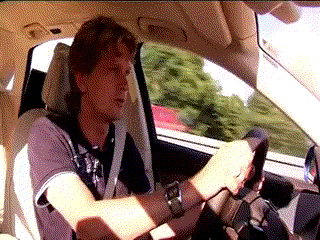

In [7]:
view(ds_train[0])

In [8]:
ds_train[0]

{'video_id': 'video0',
 'caption': 'a car is shown',
 'sen_id': 77300,
 'category': 9,
 'url': 'https://www.youtube.com/watch?v=9lZi22qLlEo',
 'start time': 137.72,
 'end time': 149.44,
 'split': 'train',
 'id': 0,
 '__index_level_0__': 0}

In [9]:
# def is_url(string):
#     try:
#         result = parse.urlparse(string)
#         return all([result.scheme, result.netloc, result.path])
#     except:
#         return False

# a function to perform inference
def get_caption(model, image_processor, tokenizer, video_path):
    frames = get_frames(video_path)
    # preprocess the image
    img = image_processor(images=list(frames), return_tensors="pt").to(device)
    # generate the caption (using greedy decoding by default)
    output = model.generate(**img)
    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

In [10]:
from transformers import VisionEncoderDecoderModel, BertTokenizerFast, ViTImageProcessor, AutoImageProcessor
import os

def init_model(device):
    # encoder_model = "google/vit-base-patch16-224"
    encoder_model = "facebook/timesformer-base-finetuned-k400"
    decoder_model = "bert-base-uncased"

    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_model, decoder_model).to(device)

    # tokenizer = AutoTokenizer.from_pretrained(decoder_model)
    tokenizer = BertTokenizerFast.from_pretrained(decoder_model)

    image_processor = AutoImageProcessor.from_pretrained(encoder_model)

    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    return model, tokenizer, image_processor

In [11]:
model, tokenizer, image_processor = init_model(device)

Some weights of the model checkpoint at facebook/timesformer-base-finetuned-k400 were not used when initializing TimesformerModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TimesformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


model: a man is driving a car
target: a car is shown


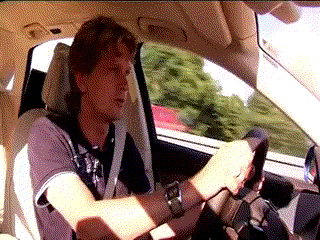

In [47]:
item = ds_train[0]
path = get_path(item['video_id'])
cap = get_caption(model, image_processor, tokenizer, path)
print('model:', cap)
view(item)

In [13]:
import torch

max_length = 32 # max length of the captions in tokens
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def preprocess(items):
    # preprocess the image
    pixel_values = image_processor([list(get_frames(get_path(x))) for x in items['video_id']], return_tensors="pt").pixel_values.to(device)
    # tokenize the caption with truncation and padding
    targets = tokenizer([caption for caption in items["caption"] ],
                        max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
    return {'pixel_values': pixel_values, 'labels': targets["input_ids"]}

# prepared_train = ds_train.with_transform(transform)
# prepared_val = ds_val.with_transform(transform)

prepared_train = ds_train.with_transform(preprocess)
prepared_val = ds_val.with_transform(preprocess)

In [14]:
# a function we'll use to collate the batches
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

In [15]:
import evaluate

# load the rouge and bleu metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
  preds = eval_pred.label_ids
  labels = eval_pred.predictions
  # decode the predictions and labels
  pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # compute the rouge score
  rouge_result = rouge.compute(predictions=pred_str, references=labels_str)
  # multiply by 100 to get the same scale as the rouge score
  rouge_result = {k: round(v * 100, 4) for k, v in rouge_result.items()}
  # compute the bleu score
  bleu_result = bleu.compute(predictions=pred_str, references=labels_str)
  # get the length of the generated captions
  generation_length = bleu_result["translation_length"]
  return {
        **rouge_result,
        "bleu": round(bleu_result["bleu"] * 100, 4),
        "gen_len": bleu_result["translation_length"] / len(preds)
  }

In [16]:
num_epochs = 2 # number of epochs
batch_size = 4 # the size of batches

In [17]:
for item in prepared_train:
  print(item["labels"].shape)
  print(item["pixel_values"].shape)
  break

torch.Size([32])
torch.Size([8, 3, 224, 224])


In [81]:
from transformers import TrainingArguments, Trainer, Seq2SeqTrainingArguments, Seq2SeqTrainer

# define the training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,             # use generate to calculate the loss
    num_train_epochs=num_epochs,            # number of epochs
    evaluation_strategy="steps",            # evaluate after each eval_steps
    eval_steps=200,                        # evaluate after each 2000 steps
    logging_steps=200,                     # log after each 2000 steps
    save_steps=200,                        # save after each 2000 steps
    # per_device_train_batch_size=batch_size, # batch size for training
    # per_device_eval_batch_size=batch_size,  # batch size for evaluation
    output_dir="timesformer-bert-video-captioning", # output directory
    auto_find_batch_size=True
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    tokenizer=image_processor,       # we use the image processor as the tokenizer
    args=training_args,              # pass the training arguments
    compute_metrics=compute_metrics, # pass the compute metrics function
    train_dataset=prepared_train,     # pass the training dataset
    eval_dataset=prepared_val,      # pass the validation dataset
    data_collator=collate_fn,        # pass the collate function
)

In [82]:
from torch.utils.data import DataLoader

def get_eval_loader(eval_dataset=None):
  return DataLoader(prepared_val, collate_fn=collate_fn, batch_size=batch_size)

# def get_test_loader(eval_dataset=None):
#   return DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

# override the get_train_dataloader, get_eval_dataloader and
# get_test_dataloader methods of the trainer
# so that we can properly load the data
trainer.get_train_dataloader = lambda: DataLoader(prepared_train, collate_fn=collate_fn, batch_size=batch_size)
trainer.get_eval_dataloader = get_eval_loader
# trainer.get_test_dataloader = get_test_loader

In [83]:
# !zip -r 'vid_cap_checkpoint-1100.zip' '/content/timesformer-bert-video-captioning/checkpoint-1700'

In [84]:
# !mv 'vid_cap_checkpoint-1700.zip' '/content/drive/MyDrive/models'

In [ ]:
trainer.train(resume_from_checkpoint='/content/timesformer-bert-video-captioning/checkpoint-2400')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


model: a man in a black shirt talks to a man
target: a man in a dark suit jacket stands in front of a blue couch and talks while holding a cell phone


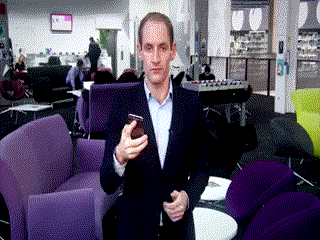

In [71]:
item = ds_train[-7]
path = get_path(item['video_id'])
cap = get_caption(model, image_processor, tokenizer, path)
print('model:', cap)
view(item)